In [1]:
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so
Profiling.logLevel=5
Profiling.verbose=False

In [2]:
import circular_tank.wavesloshing_laminar_unstruct_medium as tank
import circular_tank.wavesloshing_laminar_unstruct_medium_so as so
display_src(so)

```Python
from proteus.default_so import *
import wavesloshing_laminar_unstruct_medium

if wavesloshing_laminar_unstruct_medium.useOnlyVF:
    pnList = [("twp_navier_stokes_p", "twp_navier_stokes_n"),
              ("vof_p",               "vof_n")]
else:
    pnList = [("twp_navier_stokes_p", "twp_navier_stokes_n"),
              ("vof_p",               "vof_n"),
              ("ls_p",                "ls_n"),
              ("redist_p",            "redist_n"),
              ("ls_consrv_p",         "ls_consrv_n")]
    
    
if wavesloshing_laminar_unstruct_medium.useRANS > 0:
    pnList.append(("kappa_p",
                   "kappa_n"))
    pnList.append(("dissipation_p",
                   "dissipation_n"))
name = "wavesloshing_laminar_unstruct_medium_p" 

if wavesloshing_laminar_unstruct_medium.timeDiscretization == 'flcbdf':
    systemStepControllerType = Sequential_MinFLCBDFModelStep
    systemStepControllerType = Sequential_MinAdaptiveModelStep
else:
    systemStepControllerType = Sequential_MinAdaptiveModelStep

needEBQ_GLOBAL = False
needEBQ = False

tnList = [0.0,wavesloshing_laminar_unstruct_medium.dt_init]+[i*wavesloshing_laminar_unstruct_medium.dt_fixed for i in range(1,wavesloshing_laminar_unstruct_medium.nDTout+1)] 

info = open("TimeList.txt","w")



```


In [3]:
print tank.domain

<proteus.Domain.PlanarStraightLineGraphDomain instance at 0x7fc536e9c488>


In [4]:
%matplotlib inline
from IPython.html.widgets import interactive, fixed, FloatSlider
def buildCircularTank(he=2.0/20.0, domain=tank.domain):
    from matplotlib import pyplot, collections
    #
    #set up a cicular domain
    #
    from math import pi, ceil, cos, sin
    nvertices = nsegments = int(ceil(2.0*pi/he))
    dtheta = 2.0*pi/float(nsegments)
    vertices= []
    vertexFlags = []
    segments = []
    segmentFlags = []
    for i in range(nsegments):
        theta = pi/2.0 - i*dtheta
        vertices.append([cos(theta),sin(theta)])
        if i in [nvertices-1,0,1]:
            vertexFlags.append(domain.boundaryTags['top'])
        else:
            vertexFlags.append(boundaryTags['bottom'])
        segments.append([i,(i+1)%nvertices])
        if i in [nsegments-1,0]:
            segmentFlags.append(domain.boundaryTags['top'])
        else:
            segmentFlags.append(domain.boundaryTags['bottom'])
        boundaryTags = domain.boundaryTags
    domain = Domain.PlanarStraightLineGraphDomain(vertices=vertices,
                                                      vertexFlags=vertexFlags,
                                                      segments=segments,
                                                      segmentFlags=segmentFlags)
    #go ahead and add a boundary tags member 
    domain.boundaryTags = boundaryTags
    domain.writePoly("mesh")
    #
    #finished setting up circular domain
    #
    plot=True
    if  plot:
        domain.writePLY("mesh")
        #domain.writeAsymptote("mesh")
        triangleOptions="VApq30Dena%8.8f" % ((he**2)/2.0,)
        lines = []
        cmap = pyplot.get_cmap("hsv")
        c = []
        sF_max = float(max(domain.segmentFlags))
        for s,sF in zip(domain.segments,domain.segmentFlags):
            lines.append([domain.vertices[s[0]],domain.vertices[s[1]]])
            c.append(cmap(float(sF/sF_max)))
        lc = collections.LineCollection(lines,colors=c,linewidths=3)
        fig, ax = pyplot.subplots()
        ax.add_collection(lc)
        ax.margins(0.1)
        ax.set_aspect('equal')
    return domain
domain_widget = interactive(buildCircularTank,he=FloatSlider(min=0.0025, value=1.0/10.0, max=0.25, step=1.0/20),domain=fixed(tank.domain))

:0: FutureWarning: IPython widgets are experimental and may change in the future.


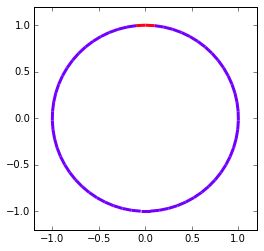

In [5]:
display(domain_widget)

In [6]:
#tank.domain = domain_widget.result

In [7]:
from proteus import Comm
from petsc4py import PETSc
import os
from importlib import import_module

pList=[]
nList=[]
so.sList=[]
OptDB = PETSc.Options()
for (p,n) in so.pnList:
    so.sList.append(default_s)
    pList.append(import_module('circular_tank.'+p))
    nList.append(import_module('circular_tank.'+n))
    pList[-1].name = p
    #nList[-1].multilevelLinearSolver = default_n.KSP_petsc4py
    #nList[-1].levelLinearSolver = default_n.KSP_petsc4py
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"ksp_type", "preonly")
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_type", "lu")
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_factor_mat_solver_package","superlu_dist")
opts.save_dof = True
opts.dataDir='.'
opts.probDir='.'
Profiling.logLevel=3
Profiling.verbose=True

In [8]:
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)

[       0] Initializing NumericalSolution for wavesloshing_laminar_unstruct_medium_p
 System includes: 
twp_navier_stokes_p
vof_p
ls_p
redist_p
ls_consrv_p

[       0] Setting Archiver(s)
[       0] Setting up MultilevelMesh
[       0] Building one multilevel mesh for all models
[       0] Generating mesh for twp_navier_stokes_p
[       0] Calling Triangle to generate 2D mesh fortwp_navier_stokes_p
TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00030584 
[       1] Converting to Proteus Mesh
[       1] Generating 1-level mesh from coarse Triangle mesh
[       1] Partitioning mesh among 1 processors using partitioningType = 1
[       1] Number of Subdomain Elements Owned= 16212
[       1] Number of Subdomain Elements = 16212
[       1] Number of Subdomain Nodes Owned= 8248
[       1] Number of Subdomain Nodes = 8248
[       1] Number of Subdomain elementBoundaries Owned= 24459
[       1] Number of Subdomain elementBoundaries = 24459
[       1] Number of Subdomain Edges Owned= 24459
[  

In [9]:
ns.calculateSolution('circular_tank')

[       9] Setting initial conditions
[       9] Setting initial conditions for twp_navier_stokes_p
[       9] Setting initial conditions on model twp_navier_stokes_p
[      10] Setting initial conditions for vof_p
[      10] Setting initial conditions on model vof_p
[      10] Setting initial conditions for ls_p
[      10] Setting initial conditions on model ls_p
[      10] Setting initial conditions for redist_p
[      10] Setting initial conditions on model redist_p
[      10] Setting initial conditions for ls_consrv_p
[      10] Setting initial conditions on model ls_consrv_p
[      10] Attaching models and running spin-up step if requested
[      10] Attaching models in LevelSetConservation
[      10] Archiving initial conditions
[      10] Estimating initial time derivative and initializing time history for model twp_navier_stokes_p
[      11] Maximum CFL = 0.0
[      11] RANS2P: max numDiff_1 1.801840e-04 numDiff_2 1.801840e-04 numDiff_3 1.801840e-04
[      11] Maximum CFL = 0.0

KeyboardInterrupt: 